# Synthetic Data on Healthcare

This notebook is a demonstration on how to use SQLSynthGen for generating synthetic data, for a healthcare use case.

## Initial Setup

In [1]:
%load_ext autoreload
%autoreload 2

from os import chdir

HOME_DIRECTORY: str = "/home/jovyan"

chdir(HOME_DIRECTORY)

import seaborn as sns
from lib import healthcare_demo

## De-Identification

Let's take a look at what's stored in the database. The `dataset` column has a value of `1` for patients with liver disease, and a value of `2` for no disease.

Notice no name, address, phone-number or email address are part of the data included.

In [2]:
import pandas as pd

DATABASE_NAME: str = "db"

connection, _ = healthcare_demo.connect_to_postgress(DATABASE_NAME)
patient_data = pd.read_sql_query(
    "SELECT * FROM indian_liver_patient", con=connection
)

patient_data

/tmp/ipykernel_490/878618893.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  patient_data = pd.read_sql_query(


,age,gender,total_bilirubin,direct_bilirubin,alkaline_phosphotase,alamine_aminotransferase,aspartate_aminotransferase,total_protiens,albumin,albumin_and_globulin_ratio,dataset,id
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1,2
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1,3
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1,4
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
578,60,Male,0.5,0.1,500,20,34,5.9,1.6,0.37,2,579
579,40,Male,0.6,0.1,98,35,31,6.0,3.2,1.10,1,580
580,52,Male,0.8,0.2,245,48,49,6.4,3.2,1.00,1,581
581,31,Male,1.3,0.5,184,29,32,6.8,3.4,1.00,1,582


# Linkage Attacks

Let us image we have a target that we now was part of this study, that does not want us to know their results. 

Let us also imagine that we know the target has 44 years old.

In [3]:
TARGET_AGE: int = 44
patient_data.query(f"age == {TARGET_AGE}")

,age,gender,total_bilirubin,direct_bilirubin,alkaline_phosphotase,alamine_aminotransferase,aspartate_aminotransferase,total_protiens,albumin,albumin_and_globulin_ratio,dataset,id
171,44,Female,1.9,0.6,298,378,602,6.6,3.3,1.0,1,172
257,44,Male,0.8,0.2,335,148,86,5.6,3.0,1.1,1,258
316,44,Male,0.9,0.2,182,29,82,7.1,3.7,1.0,2,317


Now we know that there's a **2/3 probability** that this target has liver disease. Now, let us consider we receive additional information about their `gender`:

In [4]:
TARGET_GENDER: str = "Female"
patient_data.query(f"age == {TARGET_AGE} and gender == '{TARGET_GENDER}'")

,age,gender,total_bilirubin,direct_bilirubin,alkaline_phosphotase,alamine_aminotransferase,aspartate_aminotransferase,total_protiens,albumin,albumin_and_globulin_ratio,dataset,id
171,44,Female,1.9,0.6,298,378,602,6.6,3.3,1.0,1,172


We have learned **against the target's will** that she has liver disease. Now, let's check how many people can we identify if we only know their age:


Text(0, 0.5, 'Number of occurrences')

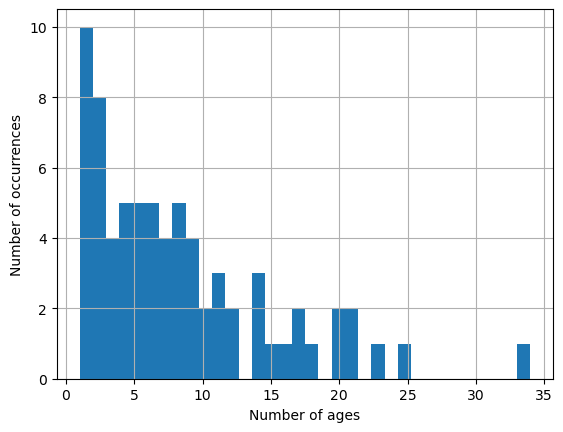

In [5]:
import matplotlib.pyplot as plt

age_counts: pd.DataFrame = patient_data["age"].value_counts()
NUMBER_OF_BINS: int = max(age_counts)

age_counts.hist(bins=NUMBER_OF_BINS)
plt.xlabel("Number of ages")
plt.ylabel("Number of occurrences")


## Aggregation

To avoid this situations, a common approach is to only release aggregate information. For example, let's release the average `albumin` per age group:

In [18]:
import numpy as np

age_and_albumin: pd.DataFrame = patient_data[["age", "albumin"]]

albumin_per_age_group: pd.DataFrame = age_and_albumin.groupby(
    pd.cut(patient_data["age"], np.arange(0, 95, 5))
).mean()

albumin_per_age_group

,age,albumin
age,,
"(0, 5]",4.000000,3.600000
"(5, 10]",7.600000,3.040000
"(10, 15]",13.000000,3.960000
"(15, 20]",17.875000,3.395833
"(20, 25]",22.724138,3.634483
"(25, 30]",27.844444,3.320000
"(30, 35]",32.936508,3.225397
"(35, 40]",38.140625,3.314062
"(40, 45]",43.379310,3.050000


Now, the average age for group `(75, 80]` corresponds to the age of a single patient, and we are actually revealing his albumin results.

In [19]:
average_age: float = 78.0
patient_data.query(f"age == {average_age}")

,age,gender,total_bilirubin,direct_bilirubin,alkaline_phosphotase,alamine_aminotransferase,aspartate_aminotransferase,total_protiens,albumin,albumin_and_globulin_ratio,dataset,id
397,78,Male,1.0,0.3,152,28,70,6.3,3.1,0.9,1,398


## Differencing Attacks

Let us imagine that our fictional target hasn't participated in the study yet. And that the researchers release total `albumin` per gender daily:

In [26]:
patient_data_without_target: pd.DataFrame = patient_data.query(
    f"age != {TARGET_AGE} or gender != '{TARGET_GENDER}'"
)

healthcare_demo.get_albumin_per_gender(patient_data_without_target)

,albumin
gender,
Female,461.5
Male,1366.9


Our target attends to the study, and inmediatly the researchers do their daily release:

In [27]:
healthcare_demo.get_albumin_per_gender(patient_data)

,albumin
gender,
Female,464.8
Male,1366.9


Now, we can easily obtain our target's albumin by `464.8 - 461.5 = 3.3`.

## K-Anonimity

Let's check for what values of `k` our dataset holds `k-anonymity`. For demonstration purposes, we consider `age`, `gender`, and `dataset` as quasi-identifiers:

In [6]:
QUASI_IDENTIFIERS: str = ["age", "gender", "dataset"]

print(
    healthcare_demo.is_k_anonymized(
        patient_data, k_value=1, quasi_identifiers=QUASI_IDENTIFIERS
    )
)

True


However, k-anonimity of `2` can be challenging:

In [7]:
print(
    healthcare_demo.is_k_anonymized(
        patient_data, k_value=2, quasi_identifiers=QUASI_IDENTIFIERS
    )
)

False


## Generalising the Data

We can attempt to reach k-anoninimity for `k=2` by rounding age to the nearest 10 years:

In [ ]:
generalised_patient_data: pd.DataFrame

## SQLSynthGen

`SQLSynthGen` is a tool for synthetic data generation in tabular format. First, let's create a replica of our `indian_liver_patient` table at the `db` database

In [8]:

%env SRC_DSN='postgresql://postgres@localhost/db'
%env DST_DSN='postgresql://postgres@localhost/db_replica'

! sqlsynthgen make-tables
! sqlsynthgen create-tables

env: SRC_DSN='postgresql://postgres@localhost/db'
env: DST_DSN='postgresql://postgres@localhost/db_replica'
/bin/bash: line 1: sqlsynthgen: command not found
/bin/bash: line 1: sqlsynthgen: command not found


The `indian_liver_patient` table should now be available in the `db_replica` database. However, it is now empty:

In [9]:
print(len(patient_data["age"].value_counts()))

with pd.option_context('display.max_rows', None):
    print(patient_data["age"].value_counts())

72
age
60    34
45    25
50    23
42    21
38    21
32    20
48    20
55    18
65    17
40    17
46    16
33    15
58    14
75    14
26    14
35    12
66    12
18    11
49    11
36    11
51    10
30    10
62     9
70     9
22     9
37     9
34     8
28     8
72     8
31     8
54     8
52     7
57     7
21     7
29     7
53     6
39     6
27     6
64     6
47     6
41     5
61     5
24     5
25     5
17     5
56     4
43     4
13     4
68     4
74     4
16     3
44     3
23     3
20     3
63     2
14     2
73     2
69     2
12     2
4      2
7      2
19     2
6      1
8      1
84     1
85     1
15     1
78     1
11     1
67     1
10     1
90     1
Name: count, dtype: int64


In [10]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,):
    print(query_dataframe[["age", "gender"]].value_counts())

NameError: name 'query_dataframe' is not defined

**10** people are identifiable by their age. We can see this better in a plot:

In [ ]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,):
    print(query_dataframe["age"].value_counts())

age
60    34
45    25
50    23
42    21
38    21
32    20
48    20
55    18
65    17
40    17
46    16
33    15
58    14
75    14
26    14
35    12
66    12
18    11
49    11
36    11
51    10
30    10
62     9
70     9
22     9
37     9
34     8
28     8
72     8
31     8
54     8
52     7
57     7
21     7
29     7
53     6
39     6
27     6
64     6
47     6
41     5
61     5
24     5
25     5
17     5
56     4
43     4
13     4
68     4
74     4
16     3
44     3
23     3
20     3
63     2
14     2
73     2
69     2
12     2
4      2
7      2
19     2
6      1
8      1
84     1
85     1
15     1
78     1
11     1
67     1
10     1
90     1
Name: count, dtype: int64


We see 10 people have 51 years, but only 1 is female